<a href="https://colab.research.google.com/github/truffleToast/DeepLearning/blob/main/Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as np
import pandas as pd # pandas
import matplotlib.pyplot as plt #그래프 그리기
from sklearn.linear_model import LinearRegression #선형분류
import statsmodels.graphics.tsaplots as sgt #  acf, pcaf 그리기
import seaborn as sns #heatmap 사용을 위해 import


In [ ]:
raw_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/deepLearning/Kaggle/data/continuous_factory_process.csv", index_col ="time_stamp")

In [ ]:
df = raw_df.drop(columns=[col for col in raw_df.columns if col.endswith('.Setpoint')]) #setPoint제거

In [ ]:
df.info()

In [ ]:
#머신러닝 순서
# 1. 문제 제시 - 완료

In [34]:
# 2. 데이터 수집 - 완료
# 내가 필요한 데이터를 바탕으로 처리
Ambient=df.iloc[:,:2] # 공장 환경변수
machine1=df.iloc[:,2:14] # machine 1 관련 변수
machine2=df.iloc[:,14:26] # machine 2 관련변수
machine3=df.iloc[:,26:38] # machine 3 관련변수
combine= df.iloc[:,38:41] #FirstStage.CombinerOperation.Temperature.U.Actual #각각 1,2,3
first_y = df.iloc[:,41:56] #  Stage1를 통해 나온 15개의 데이터 예측값
machine4=df.iloc[:,56:63] # machine 4 관련변수
machine5=df.iloc[:,63:70] # machine 5 관련변수
second_y = df.iloc[:,70:] # Stage2를 통해 나온 15개의 데이터 예측값
firstX = df.iloc[:,:38] # 처음부터 machine 3 데이터 까지


In [35]:
# Z-Score로 이상치 확인
from scipy import stats
import numpy as np
# Function to find outliers using Z-Score
def find_outliers_by_z_score(data, threshold=3):
    z_scores = np.abs(stats.zscore(data))
    return (np.where(z_scores > threshold))

# Find outliers in each section of the data using Z-Score
outliers = {
    'Ambient': find_outliers_by_z_score(Ambient),
    'machine1': find_outliers_by_z_score(machine1),
    'machine2': find_outliers_by_z_score(machine2),
    'machine3': find_outliers_by_z_score(machine3),
    'combine': find_outliers_by_z_score(combine),
    'first_y': find_outliers_by_z_score(first_y),
    'machine4': find_outliers_by_z_score(machine4),
    'machine5': find_outliers_by_z_score(machine5),
    'second_y': find_outliers_by_z_score(second_y),
    'firstX': find_outliers_by_z_score(firstX)
}
# 각 컬럼의 이상치 개수 확인
outlier_counts = {key: len(set(val[0])) for key, val in outliers.items()}
outlier_counts


{'Ambient': 0,
 'machine1': 697,
 'machine2': 860,
 'machine3': 585,
 'combine': 15,
 'first_y': 1748,
 'machine4': 342,
 'machine5': 498,
 'second_y': 2397,
 'firstX': 1473}

In [ ]:
# 이상치가 존재하니 RobustScaler를 사용하자
from sklearn.preprocessing import RobustScaler

# RobustScaler 객체 초기화
scaler = RobustScaler()

# Robust Scaling을 적용하고 스케일된 DataFrame을 반환하는 함수
def robust_scaling(data, scaler):
    # 데이터에 RobustScaler 적용
    scaled_data = scaler.fit_transform(data)
    # 스케일된 데이터를 DataFrame 형태로 변환
    scaled_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)
    return scaled_df

# 각 Stage의 입력 데이터에 Robust Scaling 적용
scaled_firstX = robust_scaling(firstX, scaler)  # 첫 번째 Stage의 입력 데이터 스케일링
scaled_machine4 = robust_scaling(machine4, scaler)  # 두 번째 Stage의 machine4 데이터 스케일링
scaled_machine5 = robust_scaling(machine5, scaler)  # 두 번째 Stage의 machine5 데이터 스케일링
scaled_first_y = robust_scaling(first_y, scaler)  # 첫 번째 Stage의 출력을 스케일링 (두 번째 Stage의 입력으로도 사용됨)

# 스케일링이 잘 적용되었는지 확인하기 위해 처음 몇 행 출력
scaled_firstX.head(), scaled_machine4.head(), scaled_machine5.head(), scaled_first_y.head()



In [30]:
# 데이터 전처리, 데이터의 상관성, 유의미한 데이터, 등을 알아보기
# 데이터 스케일링

In [38]:
#특성의 중요도를 파악하기 위해 랜덤포레스트 모델의 그래디언트 모델을 활용해서 중요하지 않은 모델은 제거를 한뒤에 딥러닝을 진행해보자

In [39]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_firstX, scaled_first_y , test_size = 0.3 ,random_state= 10) #테스트를 분리 해보자

In [46]:
# 앙상블 모델 생성
rf_model1 = RandomForestRegressor(n_estimators=100, random_state =10)
# 모델 학습
rf_model1.fit(X_train, y_train)


RandomForestRegressor(random_state=10)

In [ ]:
#모델의 특성 중요도 확인
feature_importance1 = rf_model1.feature_importances_

In [52]:
#데이터 프레임 만들어서 정렬 후 그래프화
feature_importance1_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance1})
feature_importance1_df = feature_importance1_df.sort_values('Importance', ascending=False) # importance의 value를 기준으로 내림차순

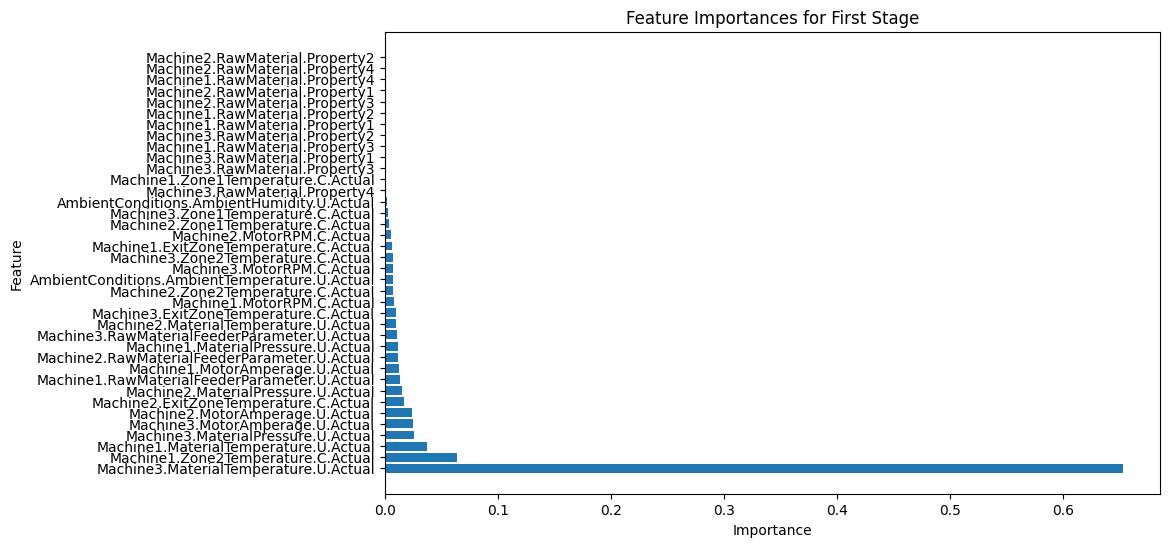

,Feature,Importance
36,Machine3.MaterialTemperature.U.Actual,0.652850
8,Machine1.Zone2Temperature.C.Actual,0.064240
12,Machine1.MaterialTemperature.U.Actual,0.037136
35,Machine3.MaterialPressure.U.Actual,0.025914
33,Machine3.MotorAmperage.U.Actual,0.024859
21,Machine2.MotorAmperage.U.Actual,0.024261
25,Machine2.ExitZoneTemperature.C.Actual,0.016633
23,Machine2.MaterialPressure.U.Actual,0.015260
6,Machine1.RawMaterialFeederParameter.U.Actual,0.013158
9,Machine1.MotorAmperage.U.Actual,0.012863


In [54]:
# 시각화
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances for First Stage")
plt.barh(feature_importance1_df['Feature'], feature_importance1_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
feature_importance1_df.head(10)


In [56]:
# importance의 값이 0.01보다 작은 값은 제거해서 처리하자
selected_features_stage1 = feature_importance1_df[feature_importance1_df['Importance']>=0.01]['Feature']


In [57]:
#새롭게 정의된 문제 데이터 , 스케일링
filtered_firstX = scaled_firstX[selected_features_stage1]
filtered_firstX.shape

(11270, 14)

In [ ]:
# 모델 선택 및 하이퍼 파라미터 선택
#LSTM으로 해보자
import tensorflow as tf #모델 선택 및 코드 간편화
from tensorflow.keras.models import Sequential  # sequence() 뼈대 가져오기
from tensorflow.keras.layers import Input, LSTM, Concatenate, Dense, Activation # 딥러닝을 위한 기초 요소
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# 모델 생성
model = Sequential()
# 모델 입력층, 은닉층, 출력층으로 나누기
#입력층
model.add(LSTM(10, activation='relu', input_shape=(36,1)))
#은닉층
model.add(Dense(200))
#출력층
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10)                480       
                                                                 
 dense_2 (Dense)             (None, 200)               2200      
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 2881 (11.25 KB)
Trainable params: 2881 (11.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 모델 예측(comfile)
## model.compile(loss ='mean_squared_error', optimizer ='adam', metrics =['mse']) #adam으로 최적화, metrics는 mse
## h1 = model.fit(x1d, y1d, epochs = 50, batch_size =1)
## h2 = model.fit(x2d, y2d, epochs = 50, batch_size =1)
## h3 = model.fit(x3d, y3d, epochs = 50, batch_size =1)


In [ ]:
# 모델학습(FIT)

In [ ]:
#모델 예측 및 평가